From original HDF5 files:

- 37 sessions (each session = 750 images)


From MindReader `nsd_utils.py`:
```raw
Extract voxels defined by roi_file.
    Served as a preprocessing to save time during sample loading.
    Write extracted vectors into hdf5 files under output_dir.

    - fmri_dir: where the fmri betas are located.
                Each beta file should have shape (750, 83, 104, 81).
    - roi_files: a list of files defining ROI. All have shape (81, 104, 83).
                 Voxels values out of interest are -1.
                 The else ranges from 0 to the (#region + 1).
    - regions: a dict. {str(roi_file_name): list(interested regions)}
               e.g. regions = {'prf-visualrois': [2, 3]}
               If provided, the funciton will only care about the voxels
               in the given regions. If None, will care about all voxels not -1.
    - flatten: if True, return a flattened vector for each fmri sample.
               (only voxels in the input roi_file are kept)
    - out_dir: where to write the new fmri to.
```

In [20]:
from glob import glob
import numpy as np
from PIL import Image

In [21]:
val_dir = '/home/jimgoo/data/neuro/val_subj01_0/'
sample = '00002'

In [22]:
glob(val_dir + f'/sample{sample}*')

['/home/jimgoo/data/neuro/val_subj01_0/sample00002.wholebrain_3d.npy',
 '/home/jimgoo/data/neuro/val_subj01_0/sample00002.wholebrain_flat.npy',
 '/home/jimgoo/data/neuro/val_subj01_0/sample00002.jpg',
 '/home/jimgoo/data/neuro/val_subj01_0/sample00002.sgxl_emb.npy',
 '/home/jimgoo/data/neuro/val_subj01_0/sample00002.nsdgeneral.npy',
 '/home/jimgoo/data/neuro/val_subj01_0/sample00002.trial.npy']

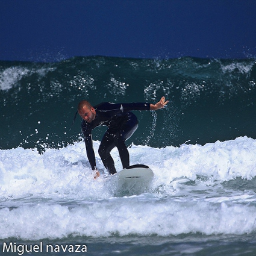

In [23]:
f = val_dir + f'sample{sample}.jpg'
Image.open(f)

In [24]:
voxels_2d = np.load(val_dir + f'sample{sample}.nsdgeneral.npy')
voxels_2d.shape

(15724,)

In [31]:
# so this is one image out of a 750 image session
voxels_3d = np.load(val_dir + f'sample{sample}.wholebrain_3d.npy')
voxels_3d.shape

(83, 104, 81)

In [26]:
np.prod(voxels_3d.shape)

699192

In [27]:
voxels_flat = np.load(val_dir + f'sample{sample}.wholebrain_flat.npy')
voxels_flat.shape

(699192,)

In [30]:
83*104, 83*81, 104*81

(8632, 6723, 8424)

In [32]:
trial = np.load(val_dir + f'sample{sample}.trial.npy')
trial.shape

(1,)

In [33]:
trial

array([2])

```raw
sample00002.wholebrain_3d.npy    (83, 104, 81)
sample00002.wholebrain_flat.npy  (699192,) which is 83 * 104 * 81
sample00002.nsdgeneral.npy       (15724,)
```

## webdataset test

In [1]:
import webdataset as wds
import time

/home/jimgoo/miniconda3/envs/medical-v1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
#url = "/home/jimgoo/data/neuro/naturalscenesdataset/webdataset/val/val_subj01_0.tar"
#url = "https://huggingface.co/datasets/pscotti/naturalscenesdataset/tree/main/webdataset/val"
#url = "https://google.com"

url = "https://huggingface.co/datasets/pscotti/naturalscenesdataset/tree/main/webdataset/val"
num_workers = 1
batch_size = 300
image_var = "images"

val_data = wds.DataPipeline([wds.SimpleShardList(url),
                    wds.tarfile_to_samples(),
                    wds.decode("torch"),
                    wds.rename(images="jpg;png", voxels="nsdgeneral.npy", embs="sgxl_emb.npy", trial="trial.npy"),
                    wds.to_tuple("voxels", image_var, "__key__"),
                    wds.batched(batch_size, partial=True),
                ]) #.with_epoch(num_worker_batches)

val_dl = wds.WebLoader(val_data, num_workers=num_workers,
                       batch_size=None, shuffle=False, persistent_workers=True)

In [ ]:
t0 = time.time()
n_batches = 0
n_samples = 0
keys = set()
for i, (voxel, im, key) in enumerate(val_dl):
    print(i, voxel.shape, len(key))
    n_batches += 1
    n_samples += voxel.shape[0]
    keys.update(key)
t1 = time.time()

# 2, 492, 492, 3.780
n_batches, n_samples, len(keys), t1-t0

0 torch.Size([300, 15724]) 300
1 torch.Size([192, 15724]) 192


(2, 492, 492, 4.057523488998413)

In [ ]:
list(keys)[:10]

['sample02943',
 'sample15329',
 'sample17573',
 'sample18091',
 'sample21100',
 'sample12521',
 'sample19523',
 'sample15532',
 'sample13023',
 'sample15613']

In [ ]:
voxel.isinf().any()

tensor(False)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.1)

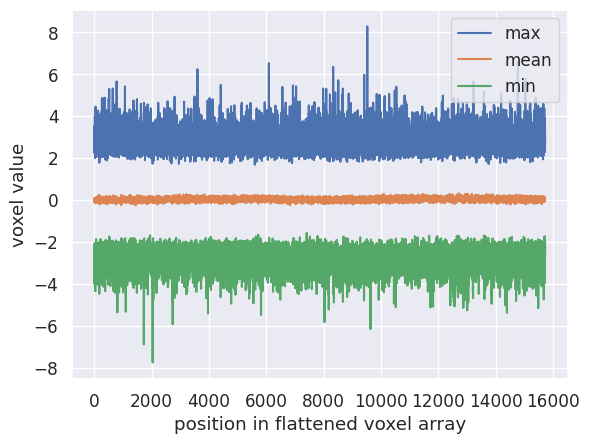

In [ ]:
# <TODO> scale the voxels once I understand more about the format of trials inside the tar dataset files
V = voxel.cpu().numpy()
plt.plot(np.vstack((np.max(V, 0), np.mean(V, 0), np.min(V, 0))).T);
plt.legend(['max', 'mean', 'min']);
plt.xlabel('position in flattened voxel array');
plt.ylabel('voxel value');

## test the webdataset loader with a HF URL

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import utils

/home/jimgoo/miniconda3/envs/medical-v1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import webdataset as wds
import time

#url = "/home/jimgoo/data/neuro/naturalscenesdataset/webdataset/val/val_subj01_0.tar"
    
url = "https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/main/webdataset/val/val_subj01_0.tar"

val_data = wds.DataPipeline([
    wds.SimpleShardList(url),
    wds.tarfile_to_samples(),
    wds.decode("torch"),
    wds.rename(images="jpg;png", voxels="nsdgeneral.npy"),
    wds.to_tuple("voxels", "images"),
    wds.batched(300, partial=True),
])

val_dl = wds.WebLoader(val_data, num_workers=1, batch_size=None, shuffle=False, persistent_workers=True)

for i, (voxel, image) in enumerate(val_dl):
    print(voxel.shape, image.shape)
    break

torch.Size([300, 15724]) torch.Size([300, 3, 256, 256])


In [9]:
train_dl, val_dl = utils.get_dataloaders(
    300,
    "images",
    num_workers=1,
    train_url="/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..49}.tar",
    val_url="/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar",
    #train_url="https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/main/webdataset/train/train_subj01_{0..49}.tar",
    #val_url="https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/main/webdataset/val/val_subj01_0.tar",
)


batch_size 300
num_devices 1
num_workers 1
global_batch_size 300
num_worker_batches 83
validation: num_worker_batches 2


In [10]:
import time
from tqdm import tqdm

def test_loader(dl):
    t0 = time.time()
    n_batches = 0
    n_samples = 0
    keys = set()
    for i, (voxel, im) in tqdm(enumerate(dl)):
        # print(i, voxel.shape, im.shape)
        n_batches += 1
        n_samples += voxel.shape[0]
        # keys.update(key)
    t1 = time.time()

    # 2, 492, 492, 3.780
    print(n_batches, n_samples, t1-t0)

In [11]:
# HF 2 600 19.57712197303772 (newer version than lo)
# lo 2 492 3.8267195224761963
test_loader(val_dl)

2it [00:03,  1.90s/it]

2 492 3.8267195224761963


In [12]:
# HF 83 24900 783.7178814411163 (newer version than lo)
# lo 83 24900 383.00872015953064
test_loader(train_dl)

83it [06:23,  4.61s/it]

83 24900 383.00872015953064


In [8]:
base_url = "https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/"

# commit = "main"
commit = "9947586218b6b7c8cab804009ddca5045249a38d"

train_url = base_url + commit + "/webdataset/train/train_subj01_{0..49}.tar"
val_url = base_url + commit + "/webdataset/val/val_subj01_0.tar",

#https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/9947586218b6b7c8cab804009ddca5045249a38d/webdataset/train/train_subj01_0.tar

